<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/preprocess/src/Testeo_Humedad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes - Humedad

In [58]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'

# NOMBRE_ESTACION = 'chucuri'
# NOMBRE_ESTACION = 'palanquero'
NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/'
PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'

FILE_DATOS_PROCESADOS = NOMBRE_ESTACION.lower() + '_procesado.csv'
FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_hum.csv'


In [60]:
df = pd.read_csv(PATH_FINAL_DADOS + FILE_DATOS_PROCESADOS, 
                 sep = ';', 
                 parse_dates = ["FECHA"],
                 date_parser = lambda col: pd.to_datetime(col)
                )

dfVar = df[['FECHA', 'HUM']].copy()
dfVar = dfVar.sort_values(by=['FECHA']).reset_index(drop = True)
dfVar

,FECHA,HUM
0,2011-01-01 01:00:00-05:00,98.0
1,2011-01-01 02:00:00-05:00,99.0
2,2011-01-01 03:00:00-05:00,100.0
3,2011-01-01 04:00:00-05:00,100.0
4,2011-01-01 05:00:00-05:00,100.0
...,...,...
52238,2017-12-31 19:00:00-05:00,93.0
52239,2017-12-31 20:00:00-05:00,97.0
52240,2017-12-31 21:00:00-05:00,99.0
52241,2017-12-31 22:00:00-05:00,99.0


In [61]:
# np.amax(dfVar['HUM'])
dfVar[dfVar['HUM'] > 100.0]

,FECHA,HUM
25673,2014-10-08 21:00:00-05:00,1536.0
50773,2017-10-29 03:00:00-05:00,101.0
50774,2017-10-29 04:00:00-05:00,101.0
50775,2017-10-29 05:00:00-05:00,101.0
50776,2017-10-29 06:00:00-05:00,102.0
...,...,...
52222,2017-12-31 03:00:00-05:00,102.0
52223,2017-12-31 04:00:00-05:00,102.0
52224,2017-12-31 05:00:00-05:00,101.0
52225,2017-12-31 06:00:00-05:00,101.0


## Test de rango fijo

In [62]:
h_max = 100.
h_min = 0.8
lamb_func = lambda r: np.nan if ((r > h_max) | (r < h_min)) else r
lamb_100 = lambda r : 100. if r > 100. else r

dfVar['HUM_CORREGIDO'] = dfVar['HUM'].apply(lamb_100)
dfVar['HUM_RANGO_FIJO'] = dfVar['HUM_CORREGIDO'].apply(lamb_func)
dfVar

,FECHA,HUM,HUM_CORREGIDO,HUM_RANGO_FIJO
0,2011-01-01 01:00:00-05:00,98.0,98.0,98.0
1,2011-01-01 02:00:00-05:00,99.0,99.0,99.0
2,2011-01-01 03:00:00-05:00,100.0,100.0,100.0
3,2011-01-01 04:00:00-05:00,100.0,100.0,100.0
4,2011-01-01 05:00:00-05:00,100.0,100.0,100.0
...,...,...,...,...
52238,2017-12-31 19:00:00-05:00,93.0,93.0,93.0
52239,2017-12-31 20:00:00-05:00,97.0,97.0,97.0
52240,2017-12-31 21:00:00-05:00,99.0,99.0,99.0
52241,2017-12-31 22:00:00-05:00,99.0,99.0,99.0


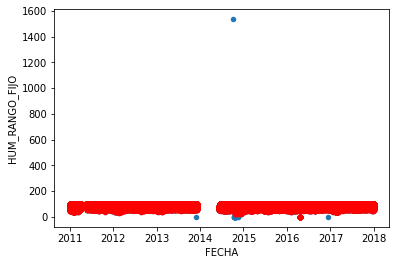

In [63]:
ax = dfVar.plot(kind = 'scatter', x='FECHA', y='HUM')
dfVar.plot(kind = 'scatter', x='FECHA', y='HUM_RANGO_FIJO', ax=ax, color='red')

In [64]:
dfVar['FECHA_DIA'] = dfVar['FECHA'].dt.date
dfAux = (dfVar.groupby('FECHA_DIA')
       .agg({'HUM_RANGO_FIJO': ['mean', 'min', 'max', 'std']})
       .reset_index(level = [0])
)

check_size_list_2 = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 3)) else 1
dfAux = (dfAux.sort_values(by = 'FECHA_DIA'))

dfAux['HUM_MIN_LIST_D_2'] = [window.to_list() for window in dfAux[('HUM_RANGO_FIJO', 'min')].rolling(window=3)]
dfAux['NO_REPETIDO_MIN_2'] = dfAux['HUM_MIN_LIST_D_2'].apply(check_size_list_2)

dfAux['HUM_MAX_LIST_D_2'] = [window.to_list() for window in dfAux[('HUM_RANGO_FIJO', 'max')].rolling(window=3)]
dfAux['NO_REPETIDO_MAX_2'] = dfAux['HUM_MAX_LIST_D_2'].apply(check_size_list_2)

dfAux['HUM_MEAN_LIST_D_2'] = [window.to_list() for window in dfAux[('HUM_RANGO_FIJO', 'mean')].rolling(window=3)]
dfAux['NO_REPETIDO_MEAN_2'] = dfAux['HUM_MEAN_LIST_D_2'].apply(check_size_list_2)

dfAux['HUM_MAX_D_1'] = (dfAux[('HUM_RANGO_FIJO', 'max')].shift(1))
dfAux['HUM_MIN_D_1'] = (dfAux[('HUM_RANGO_FIJO', 'min')].shift(1))
dfAux['HUM_MAX_D_2'] = (dfAux[('HUM_RANGO_FIJO', 'max')].shift(2))
dfAux['HUM_MIN_D_2'] = (dfAux[('HUM_RANGO_FIJO', 'min')].shift(2))

dfCons = (pd.merge(dfVar,dfAux,on='FECHA_DIA', how='outer')
            .rename(columns = {('HUM_RANGO_FIJO', 'mean') : 'HUM_PROM_DIARIA',
                                 ('HUM_RANGO_FIJO', 'min') : 'HUM_MIN_DIARIA',
                                 ('HUM_RANGO_FIJO', 'max') : 'HUM_MAX_DIARIA',
                                 ('HUM_RANGO_FIJO', 'std') : 'HUM_STD_DIARIA',
                                 ('HUM_MAX_D_1', ''): 'HUM_MAX_D_1',
                                 ('NO_REPETIDO_MIN_2', ''): 'NO_REPETIDO_MIN_2',
                                 ('NO_REPETIDO_MAX_2', ''): 'NO_REPETIDO_MAX_2',
                                 ('NO_REPETIDO_MEAN_2', ''): 'NO_REPETIDO_MEAN_2',
                              ('HUM_MIN_D_1', ''): 'HUM_MIN_D_1',})
        )

dfCons['HUM'] = dfCons['HUM_RANGO_FIJO']
dfCons['FECHA_DIA'] = dfCons['FECHA_DIA'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfCons['HUM_SH_2'] = (dfCons['HUM'].shift(1))

dfCons['FORM_2_40'] = np.where((dfCons['HUM_MAX_DIARIA'] > dfCons['HUM_PROM_DIARIA']) 
                                    & (dfCons['HUM_MIN_DIARIA'] < dfCons['HUM_PROM_DIARIA']), 1, 0)

ant_null_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & df[t_ant].isnull()
ant_notnull_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & ~df[t_ant].isnull()

dfCons['FORM_2_45'] = np.where((dfCons['FORM_2_40'] == 1) & ((ant_null_act_notnull(dfCons, 'HUM', 'HUM_SH_2')) | (abs(dfCons['HUM'] - dfCons['HUM_SH_2']) < 45 )), 1, 0)
dfCons['FORM_2_46'] = np.where((dfCons['FORM_2_45'] == 1) & (dfCons['NO_REPETIDO_MAX_2'] == 1), 1, 0)
dfCons['FORM_2_47'] = np.where((dfCons['FORM_2_46'] == 1) & (dfCons['NO_REPETIDO_MIN_2'] == 1), 1, 0)
dfCons['FORM_2_48'] = np.where((dfCons['FORM_2_47'] == 1) & (dfCons['NO_REPETIDO_MEAN_2'] == 1), 1, 0)

####  Quedamos en la formula 2.48 #####

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [65]:
## Para filtrar los valores finales
dfFinal = dfCons[dfCons['FORM_2_48'] == 1].reset_index(drop=True)
dfFinal 

,FECHA,HUM,HUM_CORREGIDO,HUM_RANGO_FIJO,FECHA_DIA,HUM_PROM_DIARIA,HUM_MIN_DIARIA,HUM_MAX_DIARIA,HUM_STD_DIARIA,"(HUM_MIN_LIST_D_2, )",NO_REPETIDO_MIN_2,"(HUM_MAX_LIST_D_2, )",NO_REPETIDO_MAX_2,"(HUM_MEAN_LIST_D_2, )",NO_REPETIDO_MEAN_2,HUM_MAX_D_1,HUM_MIN_D_1,"(HUM_MAX_D_2, )","(HUM_MIN_D_2, )",HUM_SH_2,FORM_2_40,FORM_2_45,FORM_2_46,FORM_2_47,FORM_2_48
0,2011-01-01 01:00:00-05:00,98.0,98.0,98.0,2011-01-01,80.130435,47.0,100.0,19.487302,[47.0],1,[100.0],1,[80.1304347826087],1,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1
1,2011-01-01 02:00:00-05:00,99.0,99.0,99.0,2011-01-01,80.130435,47.0,100.0,19.487302,[47.0],1,[100.0],1,[80.1304347826087],1,NaN,NaN,NaN,NaN,98.0,1,1,1,1,1
2,2011-01-01 03:00:00-05:00,100.0,100.0,100.0,2011-01-01,80.130435,47.0,100.0,19.487302,[47.0],1,[100.0],1,[80.1304347826087],1,NaN,NaN,NaN,NaN,99.0,1,1,1,1,1
3,2011-01-01 04:00:00-05:00,100.0,100.0,100.0,2011-01-01,80.130435,47.0,100.0,19.487302,[47.0],1,[100.0],1,[80.1304347826087],1,NaN,NaN,NaN,NaN,100.0,1,1,1,1,1
4,2011-01-01 05:00:00-05:00,100.0,100.0,100.0,2011-01-01,80.130435,47.0,100.0,19.487302,[47.0],1,[100.0],1,[80.1304347826087],1,NaN,NaN,NaN,NaN,100.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51280,2017-12-31 19:00:00-05:00,93.0,93.0,93.0,2017-12-31,88.166667,56.0,100.0,15.409389,"[66.0, 66.0, 56.0]",1,"[100.0, 100.0, 100.0]",1,"[92.79166666666667, 90.79166666666667, 88.1666...",1,100.0,66.0,100.0,66.0,86.0,1,1,1,1,1
51281,2017-12-31 20:00:00-05:00,97.0,97.0,97.0,2017-12-31,88.166667,56.0,100.0,15.409389,"[66.0, 66.0, 56.0]",1,"[100.0, 100.0, 100.0]",1,"[92.79166666666667, 90.79166666666667, 88.1666...",1,100.0,66.0,100.0,66.0,93.0,1,1,1,1,1
51282,2017-12-31 21:00:00-05:00,99.0,99.0,99.0,2017-12-31,88.166667,56.0,100.0,15.409389,"[66.0, 66.0, 56.0]",1,"[100.0, 100.0, 100.0]",1,"[92.79166666666667, 90.79166666666667, 88.1666...",1,100.0,66.0,100.0,66.0,97.0,1,1,1,1,1
51283,2017-12-31 22:00:00-05:00,99.0,99.0,99.0,2017-12-31,88.166667,56.0,100.0,15.409389,"[66.0, 66.0, 56.0]",1,"[100.0, 100.0, 100.0]",1,"[92.79166666666667, 90.79166666666667, 88.1666...",1,100.0,66.0,100.0,66.0,99.0,1,1,1,1,1


In [66]:
print(f'Datos iniciales : {dfVar.shape[0]}')
print(f'Datos nulos : {dfVar[dfVar["HUM"].isnull()].shape[0]}')
print(f'Datos nulos después de los testes : {dfFinal[dfFinal["HUM"].isnull()].shape[0]}')
print(f'Datos finales después de testes : {dfFinal.shape[0]}')
print(f'Datos no nulos que fueron eliminados en los testes : {dfVar.shape[0] - dfFinal.shape[0] - dfVar[dfVar["HUM"].isnull()].shape[0]}')

Datos iniciales : 52243
Datos nulos : 900
Datos nulos después de los testes : 0
Datos finales después de testes : 51285
Datos no nulos que fueron eliminados en los testes : 58


In [67]:
dfFinal[['FECHA', 'HUM']].to_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS, header=True, index=False, sep = ';')